In [1]:
import numpy as np
import pandas as pd

# find skills and non-skills with word vectors
df_skills = pd.read_csv('raw_known_skills.tsv',sep='\t')
df_skills = df_skills[df_skills['has vec'] != 0]
df_non_skills = pd.read_csv('raw_non_skills.tsv',sep='\t')
df_non_skills = df_non_skills[df_non_skills['has vec'] != 0]



In [2]:
df_non_skills['skill']=0
df_non_skills.head()



,Unnamed: 0,skill_uuid,skill_name,has vec,vec,total_count,n,pmi,ngram,skill
3,3,b7bfb94927c40577c1019e0084d73297,woods,1,"[-0.025314536, -0.12206448, -0.15730749, -0.03...",4,1,NaN,woods,0
9,9,fedcf9bd957a1f9acca6ef0bf5ae7145,localized,1,"[-0.02288163, -0.022606501, -0.03828672, -0.04...",2,1,NaN,localized,0
12,12,84eaacae3b4d0ea91b336e5ca738e407,originality,1,"[-0.01041184, 0.09316494, 0.09193976, 0.002960...",1,1,NaN,originality,0
18,18,b29a3099fe2e30ae7b6e580c6ac6482c,citrus,1,"[-0.01657359, 0.08777158, 0.09029454, 0.080935...",3,1,NaN,citrus,0
19,19,82d5adc7cec7cd114704a2a38438f2b6,stipulate,1,"[0.0032493414, -0.0073060635, -0.010555056, -0...",2,1,NaN,stipulate,0


In [3]:
df_skills['skill']=1
df_skills.head()

,Unnamed: 0,skill_uuid,skill_name,has vec,vec,ONET KSA,O*NET-SOC Code,Element ID,Description,skill
2,2,1cea5345d284f36245a94301b114b27c,writing,1,"[-0.42986488, 0.23410372, 0.06765873, 0.290670...",writing,11-1011.00,2.a.1.c,communicating effectively in writing as approp...,1
3,3,d1715efc5a67ac1c988152b8136e3dfa,speaking,1,"[-0.19923058, -0.15554935, -0.002257321, 0.100...",speaking,11-1011.00,2.a.1.d,talking to others to convey information effect...,1
4,4,6ae28a55456b101be8261e5dee44cd3e,mathematics,1,"[0.27733484, -0.4195724, 0.4989914, 0.04852456...",mathematics,11-1011.00,2.a.1.e,using mathematics to solve problems.,1
5,5,fb5c7f9bb4b32ce2f3bff4662f1ab27b,science,1,"[0.1024806, -0.038780533, 0.3325959, 0.0884522...",science,11-1011.00,2.a.1.f,using scientific rules and methods to solve pr...,1
6,6,20784bf09c9fe614603ad635e6093ede,critical thinking,1,"[-0.16684124, 0.0053465497, 0.086651236, 0.112...",critical thinking,11-1011.00,2.a.2.a,using logic and reasoning to identify the stre...,1


In [4]:
df = df_skills.append(df_non_skills)
df.head()
print df[df['skill']==1].count()
print '-----------'
print df[df['skill']==0].count()
print '-----------'


Description        50
Element ID        211
O*NET-SOC Code    211
ONET KSA          211
Unnamed: 0        211
has vec           211
n                   0
ngram               0
pmi                 0
skill             211
skill_name        211
skill_uuid        211
total_count         0
vec               211
dtype: int64
-----------
Description           0
Element ID            0
O*NET-SOC Code        0
ONET KSA              0
Unnamed: 0        59288
has vec           59288
n                 59288
ngram             59288
pmi               45579
skill             59288
skill_name        59288
skill_uuid        59288
total_count       59288
vec               59288
dtype: int64
-----------


In [5]:
from sklearn import svm
import ast 

# pandas thinks the word vectors are a string
X = df.vec.apply(ast.literal_eval).values
X = np.vstack(X)
y = df.skill.values


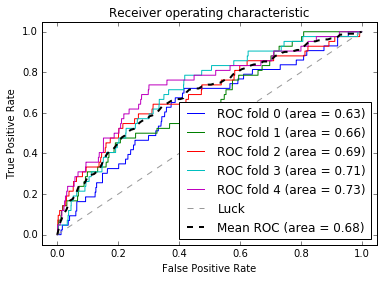

In [6]:
%matplotlib inline
###############################################################################
# Classification and ROC analysis
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(y, n_folds=5, shuffle=True)

# #cache_size=1Gb
# # if a lot of noisy observations, set C less than one
# # if data is unbalanced, set class_weight='balanced' and/or try different penalty parameters C
classifier = svm.SVC(kernel='rbf', C=1.0, cache_size=1000, probability=True)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

next: throw the data through a bunch of classifiers to
find the most accurate (1) parameters and (2) ensemble of models  

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

imputer = Imputer(strategy='mean', missing_values=-1)

classifier = RandomForestClassifier(n_estimators=100)

pipeline = Pipeline([
    ('imp', imputer),
    ('clf', classifier),
])
parameter_grid = {
    'clf__max_features': [0.5, 1],
    'clf__max_depth': [5, None],
}

clf_pipe = Pipeline([(),(),
                ('clf',
                 svm.SVC(kernel='rbf', 
                         C=1.0, cache_size=1000))])

